This notebook is the second part of a tutorial on Time Series Analysis using StatsModels.

It is based on Chapter 12 of [*Think Stats*, third edition](https://allendowney.github.io/ThinkStats/).

[Click here to run this notebook on Colab](https://colab.research.google.com/github/AllenDowney/ThinkStats/blob/v3/tutorial/ts/time_series_02.ipynb).

In [1]:
try:
    import empiricaldist
except ImportError:
    !pip install empiricaldist

In [2]:
from os.path import basename, exists


def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + local)


download("https://github.com/AllenDowney/ThinkStats/raw/v3/nb/thinkstats.py")

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from thinkstats import decorate

## Material from the previous notebook

In [4]:
filename = "Net_generation_for_all_sectors.csv"
download("https://github.com/AllenDowney/ThinkStats/raw/v3/data/" + filename)

In [5]:
elec = (
    pd.read_csv("Net_generation_for_all_sectors.csv", skiprows=4)
    .drop(columns=["units", "source key"])
    .set_index("description")
    .replace("--", np.nan)
    .transpose()
    .astype(float)
)

In [6]:
elec.index = pd.date_range(start="2001-01", periods=len(elec), freq="ME")

In [7]:
def plot_decomposition(original, decomposition):
    plt.figure(figsize=(6, 5))

    ax1 = plt.subplot(4, 1, 1)
    plt.plot(original, label="Original", color="C0")
    plt.ylabel("Original")

    plt.subplot(4, 1, 2, sharex=ax1)
    plt.plot(decomposition.trend, label="Trend", color="C1")
    plt.ylabel("Trend")

    plt.subplot(4, 1, 3, sharex=ax1)
    plt.plot(decomposition.seasonal, label="Seasonal", color="C2")
    plt.ylabel("Seasonal")

    plt.subplot(4, 1, 4, sharex=ax1)
    plt.plot(decomposition.resid, label="Residual", color="C3")
    plt.ylabel("Residual")

    plt.tight_layout()

In [8]:
def split_series(series, n=60):
    training = series.iloc[:-n]
    test = series.iloc[-n:]
    return training, test

In [9]:
def MAPE(predicted, actual):
    ape = np.abs(predicted - actual) / actual
    return np.mean(ape) * 100

## Multiplicative Model

The additive model we used in the previous section is based on the assumption that the time series is well modeled as the *sum* of a long-term trend, a seasonal component, and a residual -- which implies that the magnitude of the seasonal component and the residuals does not vary over time.

As an example that violates this assumption, let's look at small-scale solar electricity production since 2014.

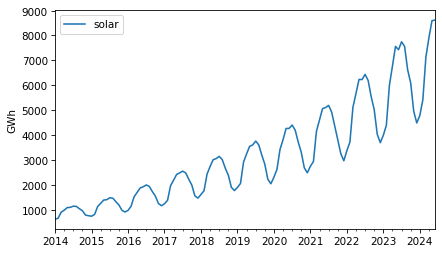

In [10]:
solar = elec["United States : small-scale solar photovoltaic"].dropna()
solar.plot(label="solar")
decorate(ylabel="GWh")

Over this interval, total production has increased several times over.
And it's clear that the magnitude of seasonal variation has increased as well.

If we suppose that the magnitudes of seasonal and random variation are proportional to the magnitude of the trend, that suggests an alternative to the additive model in which the time series is the *product* of the three components.

To try out this multiplicative model, we'll split this series into training and test sets.

In [11]:
training, test = split_series(solar)

And call `seasonal_decompose` with the `model="multiplicative"` argument.

In [12]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(training, model="multiplicative", period=12)

Here's what the results look like.

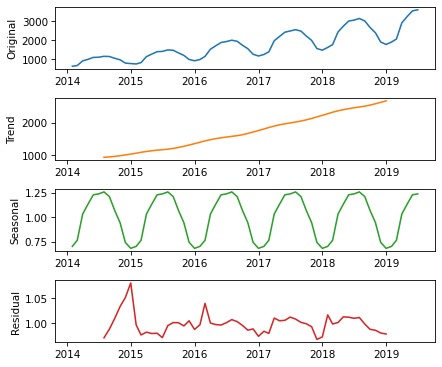

In [13]:
plot_decomposition(training, decomposition)

Now the seasonal and residual components are multiplicative factors.
So, it looks like the seasonal component varies from about 25% below the trend to 25% above.
And the residual component is usually less than 5% either way, with the exception of some larger factors in the first period.
We can extract the components of the model like this.

In [14]:
trend = decomposition.trend
seasonal = decomposition.seasonal
resid = decomposition.resid

The $R^2$ value of this model is very high.

In [15]:
rsquared = 1 - resid.var() / training.var()
rsquared

0.9999999992978134

The production of a solar panel is largely a function of the sunlight it's exposed to, so it makes sense that production follows an annual cycle so closely.

To predict the long term trend, we'll use a quadratic model.

In [16]:
import statsmodels.formula.api as smf

months = range(len(training))
data = pd.DataFrame({"trend": trend, "months": months}).dropna()
results = smf.ols("trend ~ months + I(months**2)", data=data).fit()

In the Patsy formula, the substring `I(months**2)` adds a quadratic term to the model, so we don't have to compute it explicitly.
Here are the results.

In [17]:
from thinkstats import display_summary

display_summary(results)

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,766.1962,13.494,56.782,0.000,739.106,793.286
months,22.2153,0.938,23.673,0.000,20.331,24.099
I(months ** 2),0.1762,0.014,12.480,0.000,0.148,0.205


R-squared:,0.9983


The p-values of the linear and quadratic terms are very small, which suggests that the quadratic model captures more information about the trend than a linear model would -- and the $R^2$ value is very high.

Now we can use the model to compute the expected value of the trend for the past and future.

In [18]:
months = range(len(solar))
df = pd.DataFrame({"months": months})
pred_trend = results.predict(df)
pred_trend.index = solar.index

Here's what it looks like.

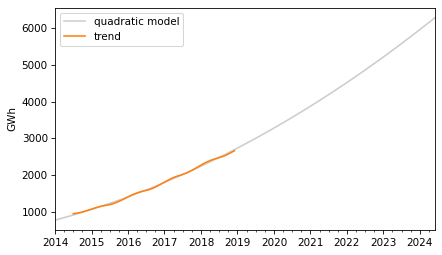

In [19]:
pred_trend.plot(color="0.8", label="quadratic model")
trend.plot(color="C1")
decorate(ylabel="GWh")

The quadratic model fits the past trend well.
Now we can use the seasonal component to predict future seasonal variation.

In [20]:
monthly_averages = seasonal.groupby(seasonal.index.month).mean()
pred_seasonal = monthly_averages[pred_trend.index.month]
pred_seasonal.index = pred_trend.index

Finally, to compute **retrodictions** for past values and predictions for the future, we multiply the trend and the seasonal component.

In [21]:
pred = pred_trend * pred_seasonal

Here is the result along with the training data.

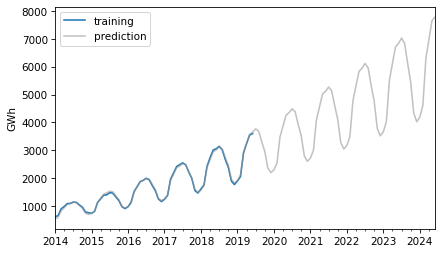

In [22]:
training.plot(label="training")
pred.plot(alpha=0.6, color="0.6", label="prediction")
decorate(ylabel="GWh")

The retrodictions fit the training data well and the predictions seem plausible -- now let's see if they turned out to be accurate.
Here are the predictions along with the test data.

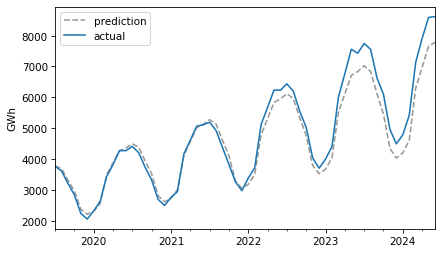

In [23]:
future = pred[test.index]
future.plot(ls="--", color="0.6", label="prediction")

test.plot(label="actual")
decorate(ylabel="GWh")

For the first three years, the predictions are very good.
After that, it looks like actual growth exceeded expectations.


### Exercise

In the previous example, we used a multiplicative seasonal decomposition to model electricity production from small-scale solar power from 2014 to 2019 and forecast production from 2019 to 2024.
As an exercise, let's do the same with utility-scale solar power.
Here's what the time series looks like.

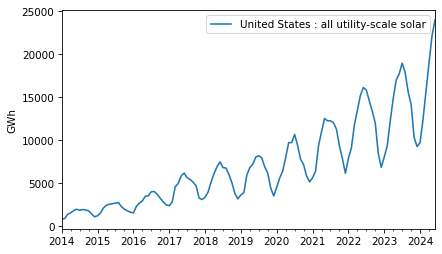

In [24]:
util_solar = elec["United States : all utility-scale solar"].dropna()
util_solar = util_solar[util_solar.index.year >= 2014]
util_solar.plot()
decorate(ylabel="GWh")

Use `split_series` to split this data into a training and test series.
Compute a multiplicative decomposition of the training series with a 12-month period.
Fit a linear or quadratic model to the trend and generate a five-year forecast, including a seasonal component.
Plot the forecast along with the test series, and compute the mean absolute percentage error (MAPE).

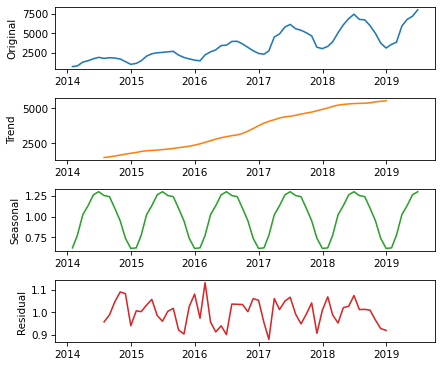

In [25]:
# Solution

training, test = split_series(util_solar)
decomposition = seasonal_decompose(training, model="multiplicative", period=12)
plot_decomposition(training, decomposition)

In [26]:
# Solution

trend = decomposition.trend
seasonal = decomposition.seasonal
resid = decomposition.resid

In [27]:
# Solution

months = np.arange(len(training))
data = pd.DataFrame({"trend": trend, "months": months}).dropna()
results = smf.ols("trend ~ months + I(months**2)", data=data).fit()
display_summary(results)

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,851.0532,115.270,7.383,0.000,619.640,1082.467
months,72.2559,8.016,9.014,0.000,56.162,88.349
I(months ** 2),0.2205,0.121,1.828,0.073,-0.022,0.463


R-squared:,0.9812


In [28]:
# Solution

months = np.arange(len(util_solar))
df = pd.DataFrame({"months": months})
pred_trend = results.predict(df)
pred_trend.index = util_solar.index

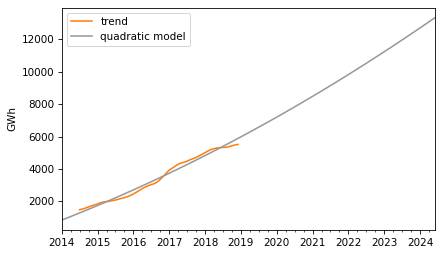

In [29]:
# Solution

trend.plot(color="C1")
pred_trend.plot(color="0.6", label="quadratic model")
decorate(ylabel="GWh")

In [30]:
# Solution

monthly_averages = seasonal.groupby(seasonal.index.month).mean()
pred_seasonal = monthly_averages[pred_trend.index.month]
pred_seasonal.index = pred_trend.index
pred = pred_trend * pred_seasonal

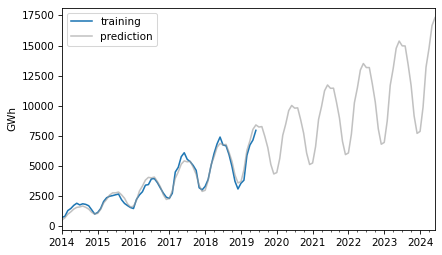

In [31]:
# Solution

training.plot(label="training")
pred.plot(alpha=0.6, color="0.6", label="prediction")
decorate(ylabel="GWh")

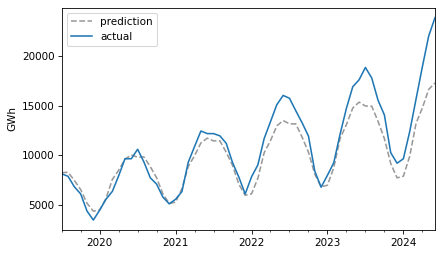

In [32]:
# Solution

# The results for the first few years are pretty good -- after that,
# actual production exceeds the predictions

future = pred[test.index]
future.plot(ls="--", color="0.6", label="prediction")

test.plot(label="actual")
decorate(ylabel="GWh")

In [33]:
# Solution

MAPE(future, test)

10.676140274761144

[Think Stats: Exploratory Data Analysis in Python, 3rd Edition](https://allendowney.github.io/ThinkStats/index.html)

Copyright 2024 [Allen B. Downey](https://allendowney.com)

Code license: [MIT License](https://mit-license.org/)

Text license: [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/)